In [5]:
%matplotlib inline

import os
from glob import glob
from collections import defaultdict

import dinopy
import yaml
import matplotlib.pyplot as plt
import seaborn
import numpy
import pandas as pd
from IPython.display import Image, display

from sh import nucmer, delta_filter, mummerplot, gnuplot, samtools, cp

from phasm.io import gfa
from phasm.assembly_graph import AssemblyGraph
from phasm.bubbles import find_superbubbles

BASE_DIR = os.path.realpath(os.path.join(os.getcwd(), '..'))

with open(os.path.join(BASE_DIR, "config.yml")) as f:
    config = yaml.load(f)
    
seaborn.set_context('paper')
seaborn.set_style('whitegrid')

In [2]:
def fix_gnuplot5(istream):
    for line in istream:
        if "clipboardformat" in line:
            continue
        
        yield line

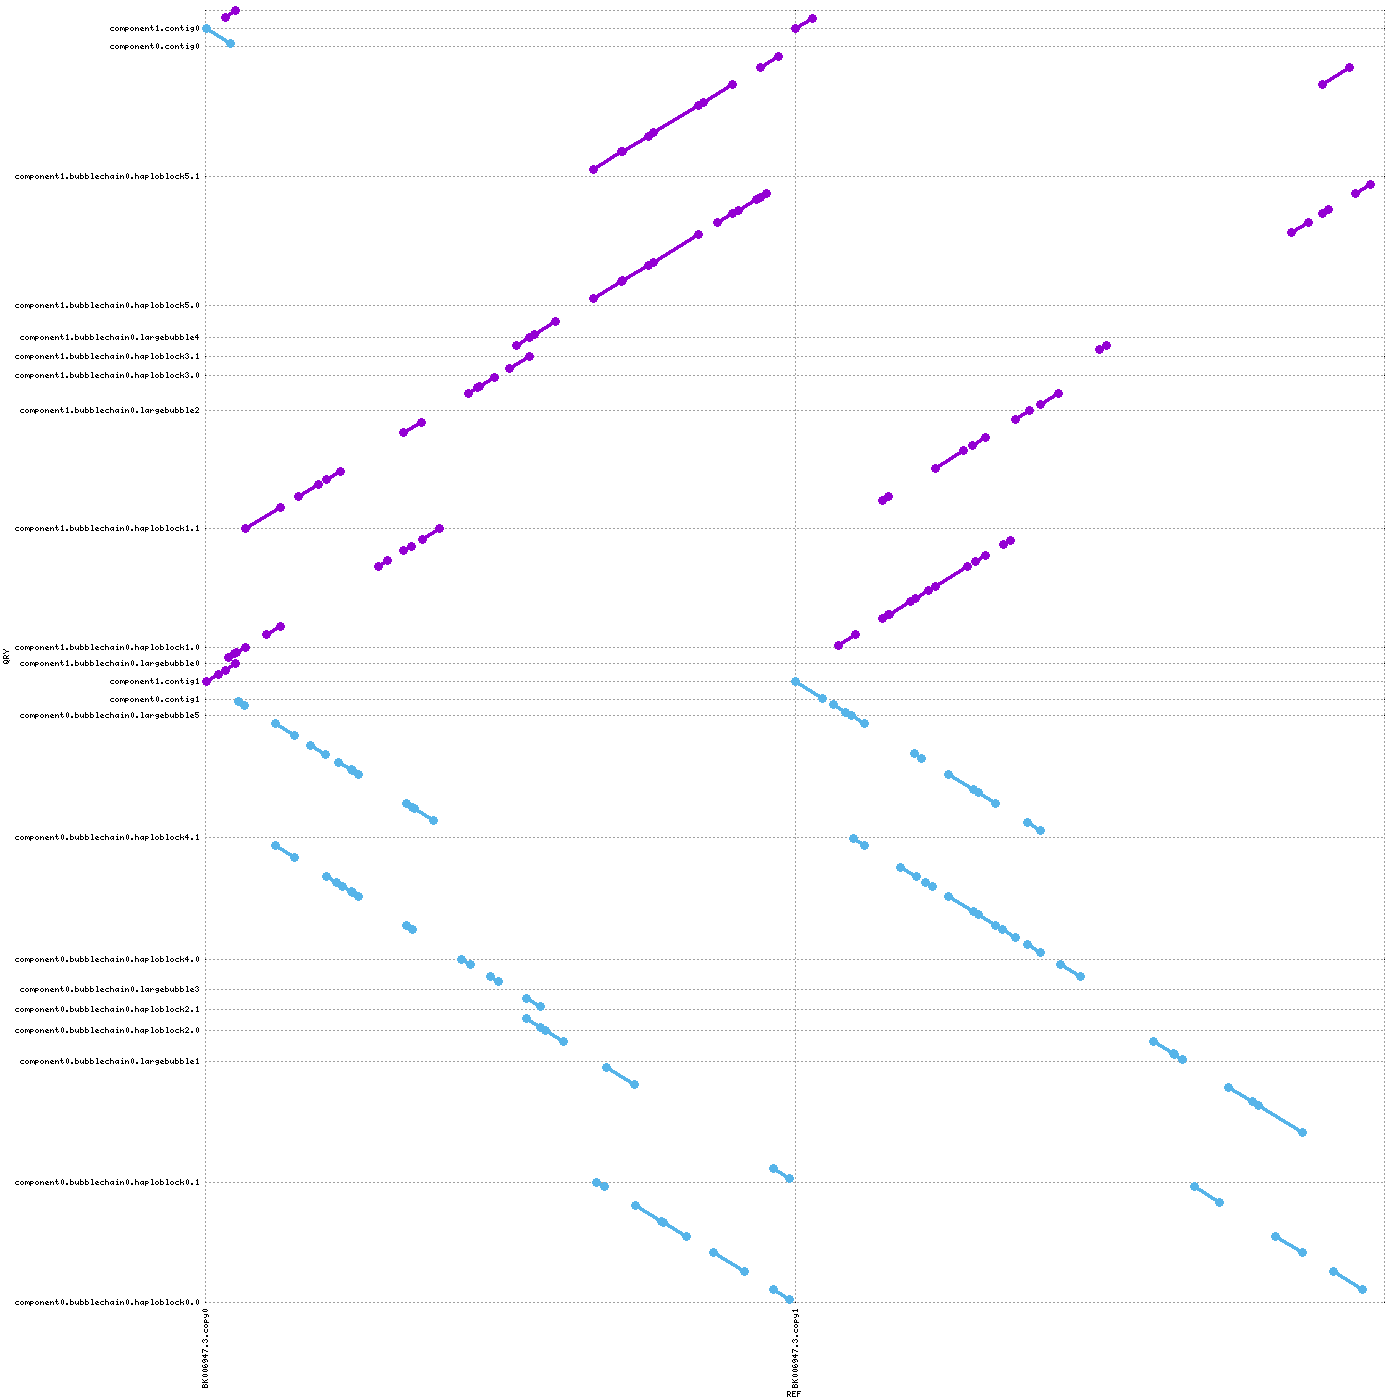

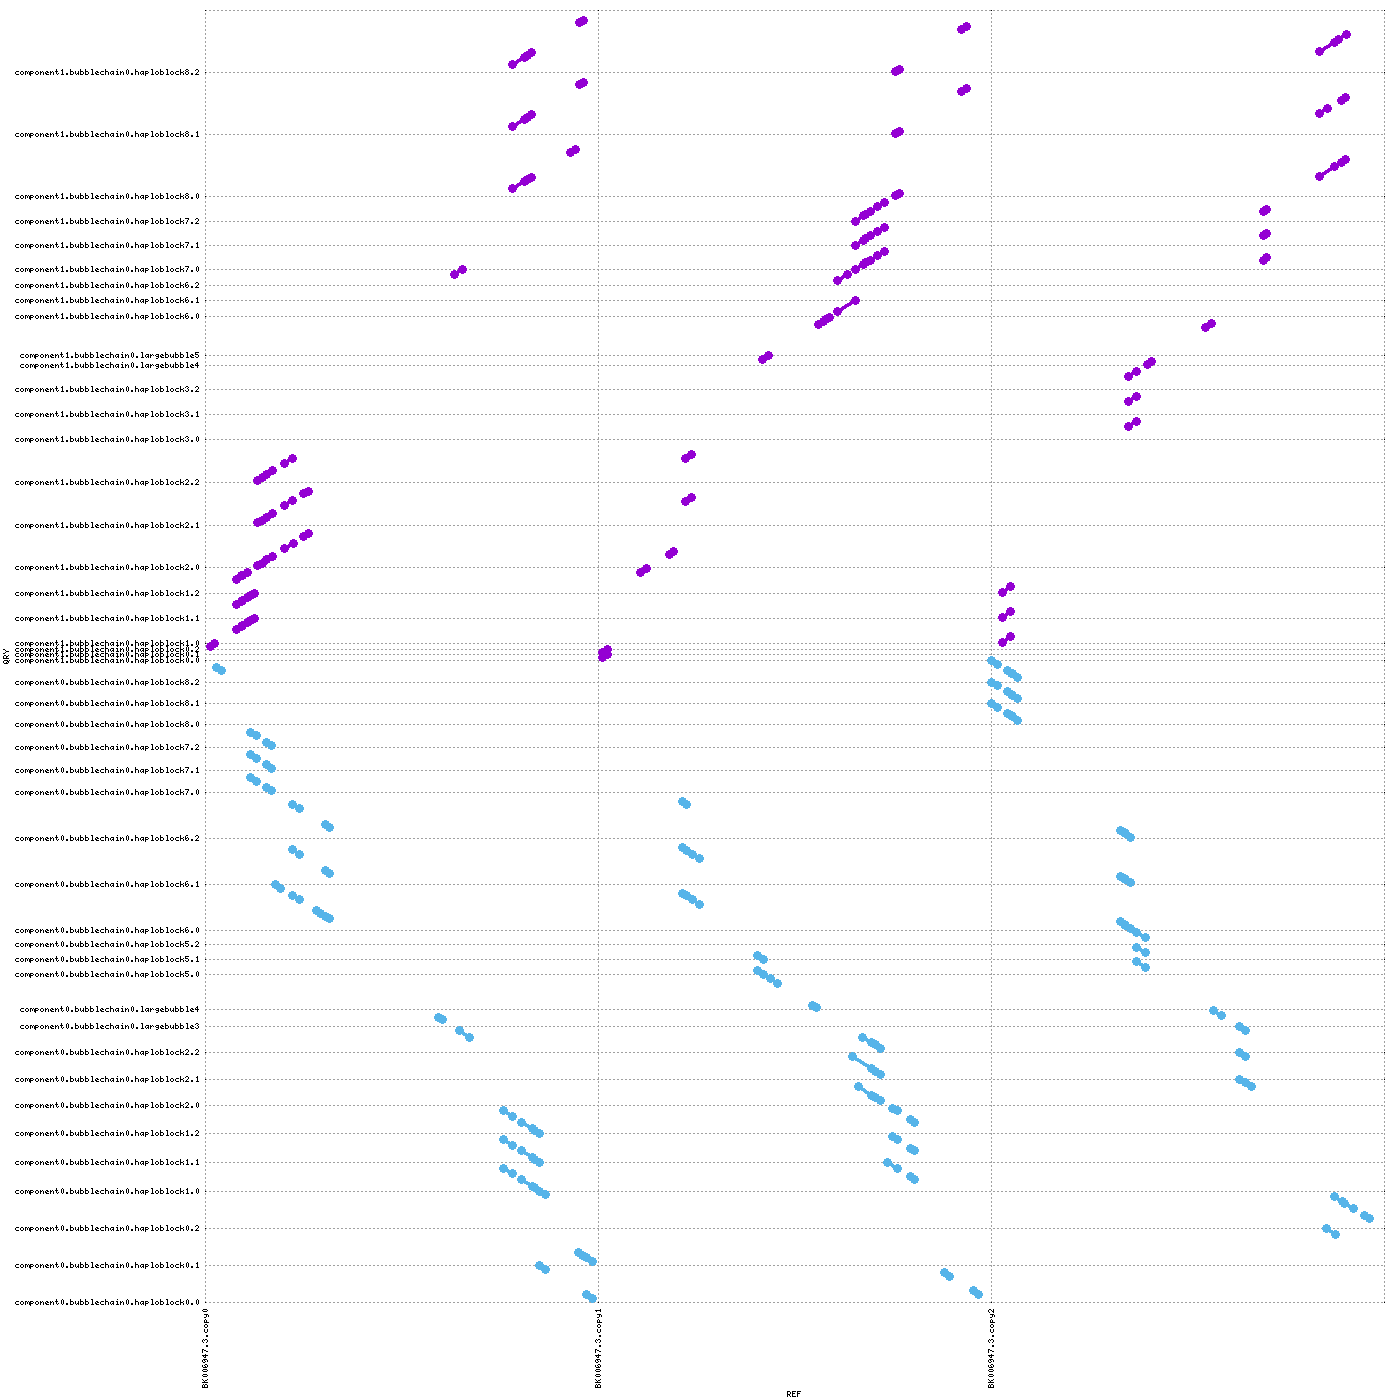

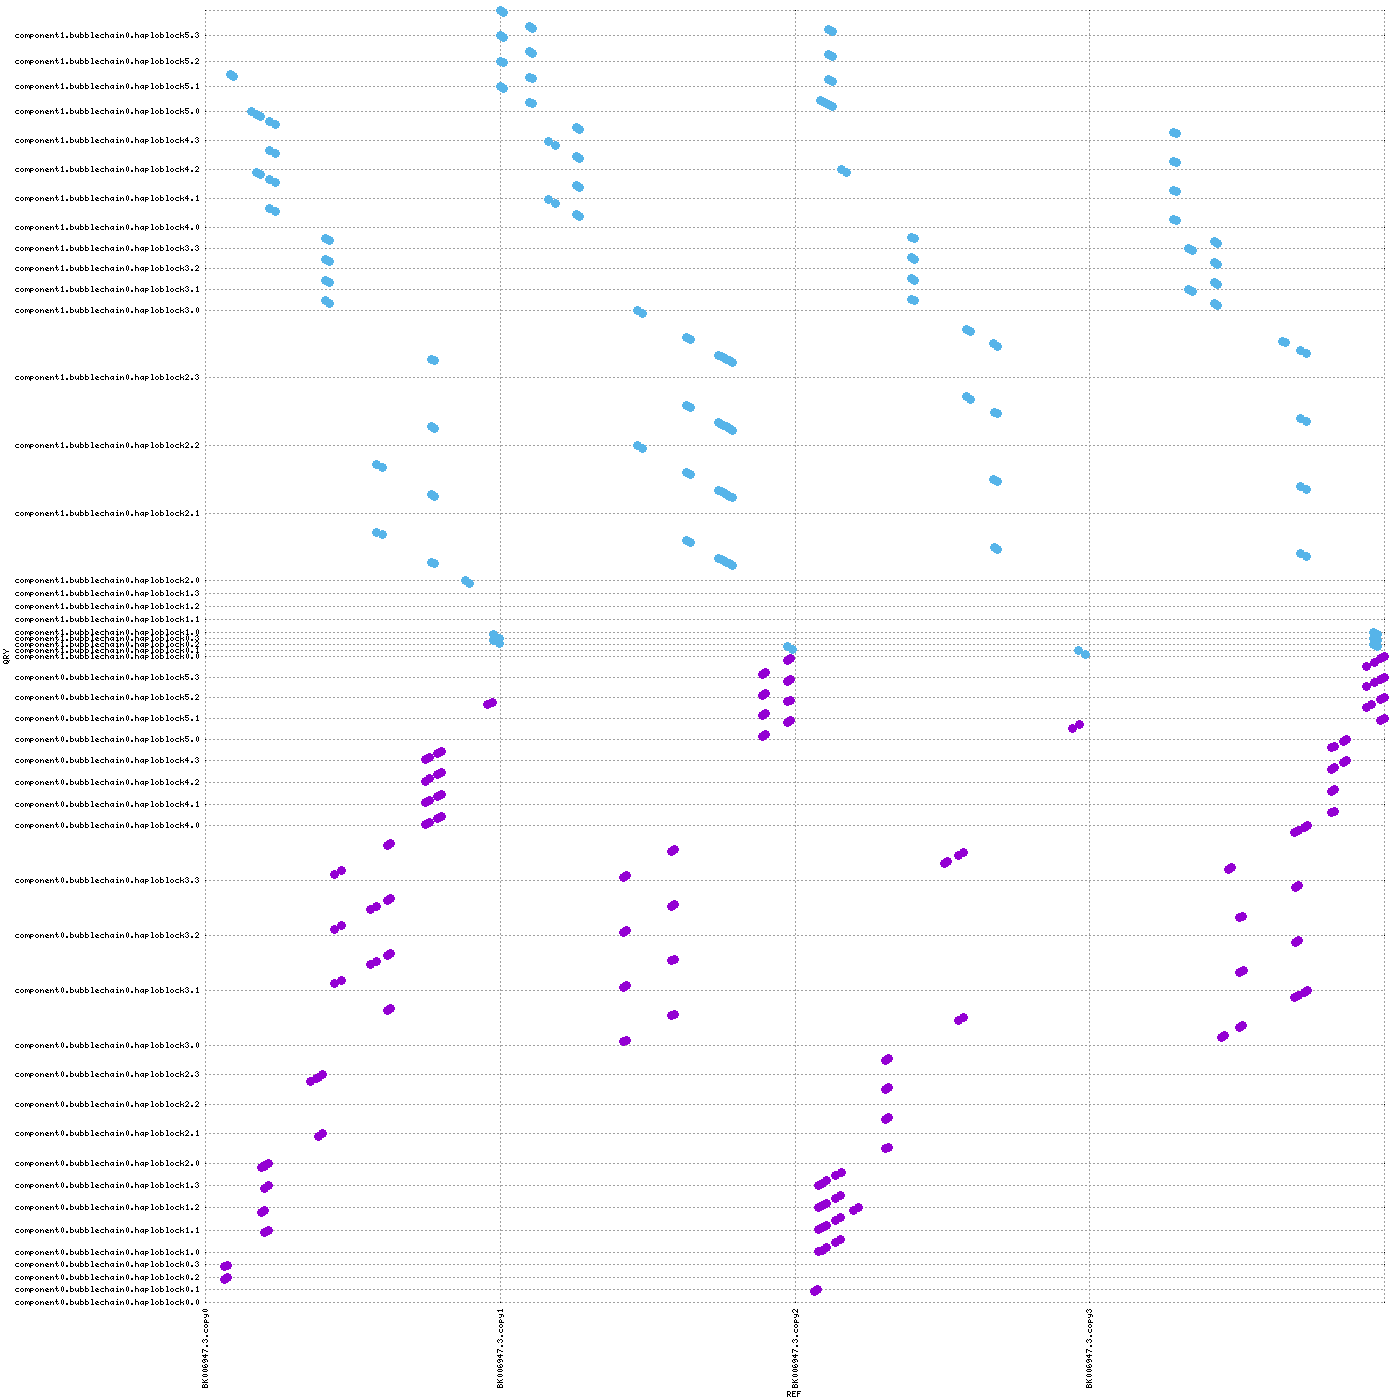

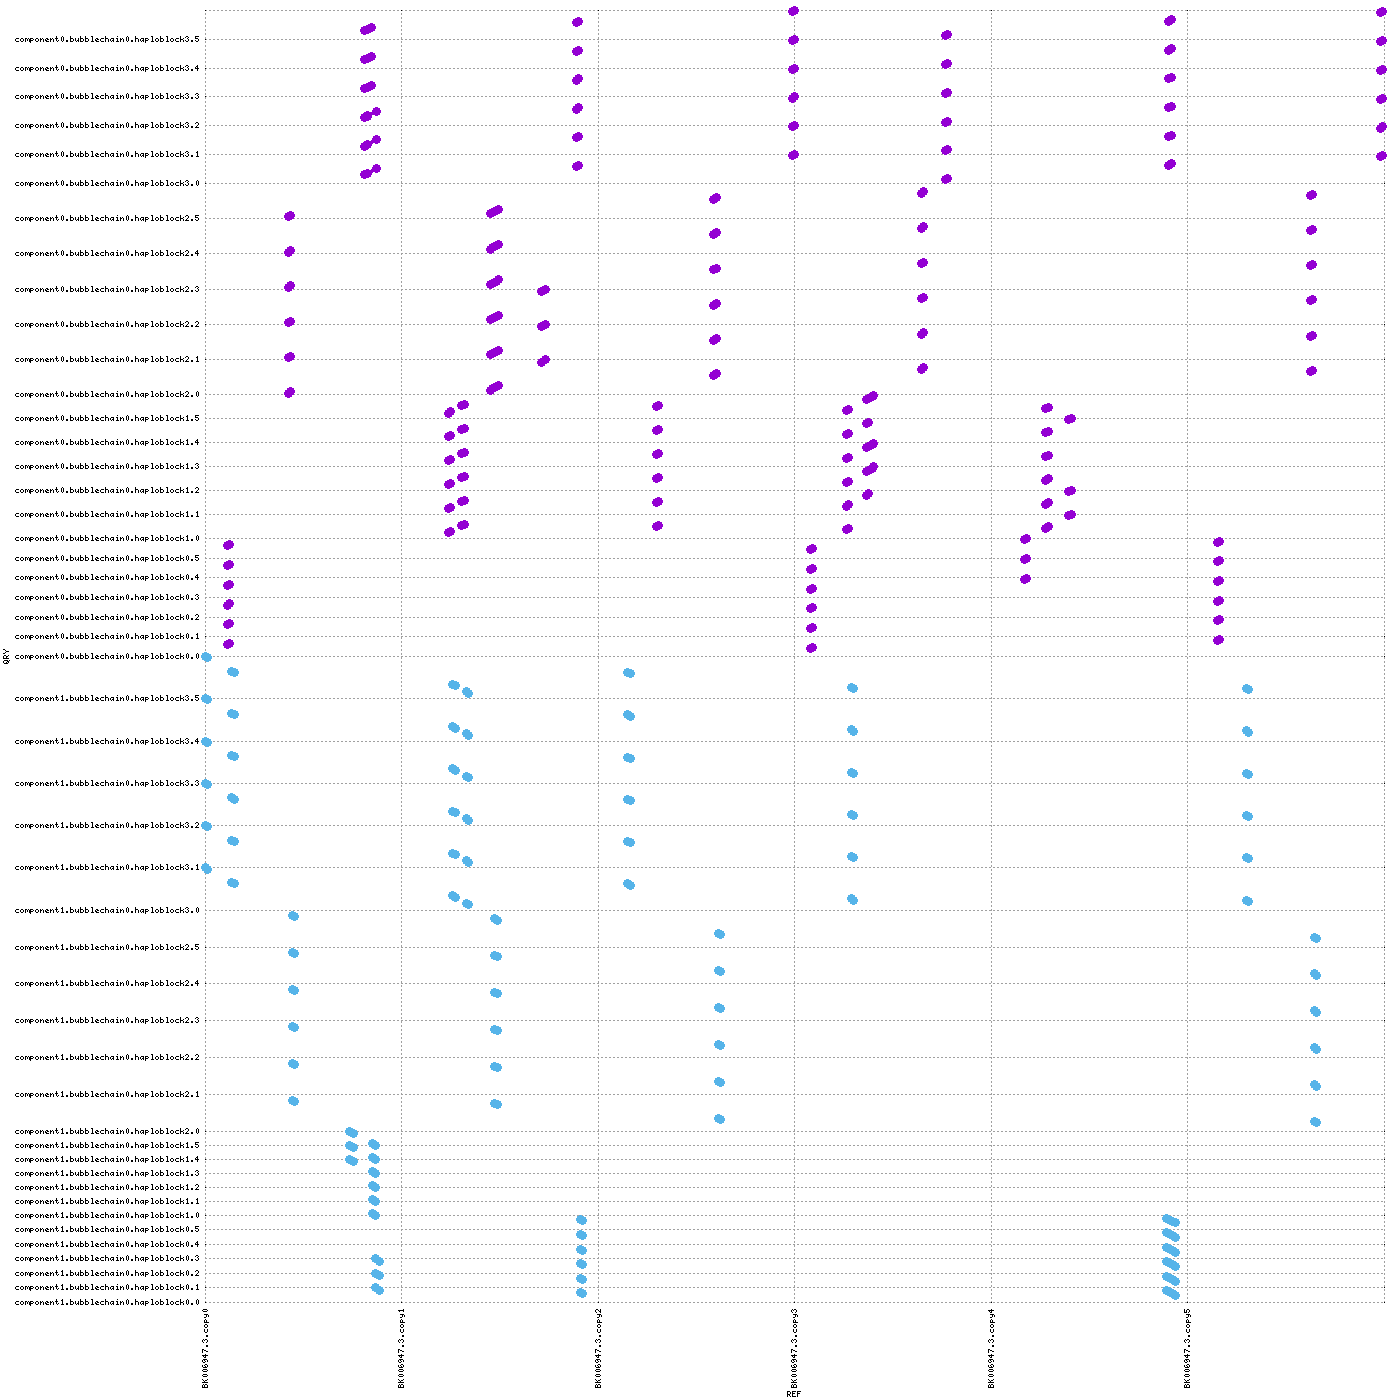

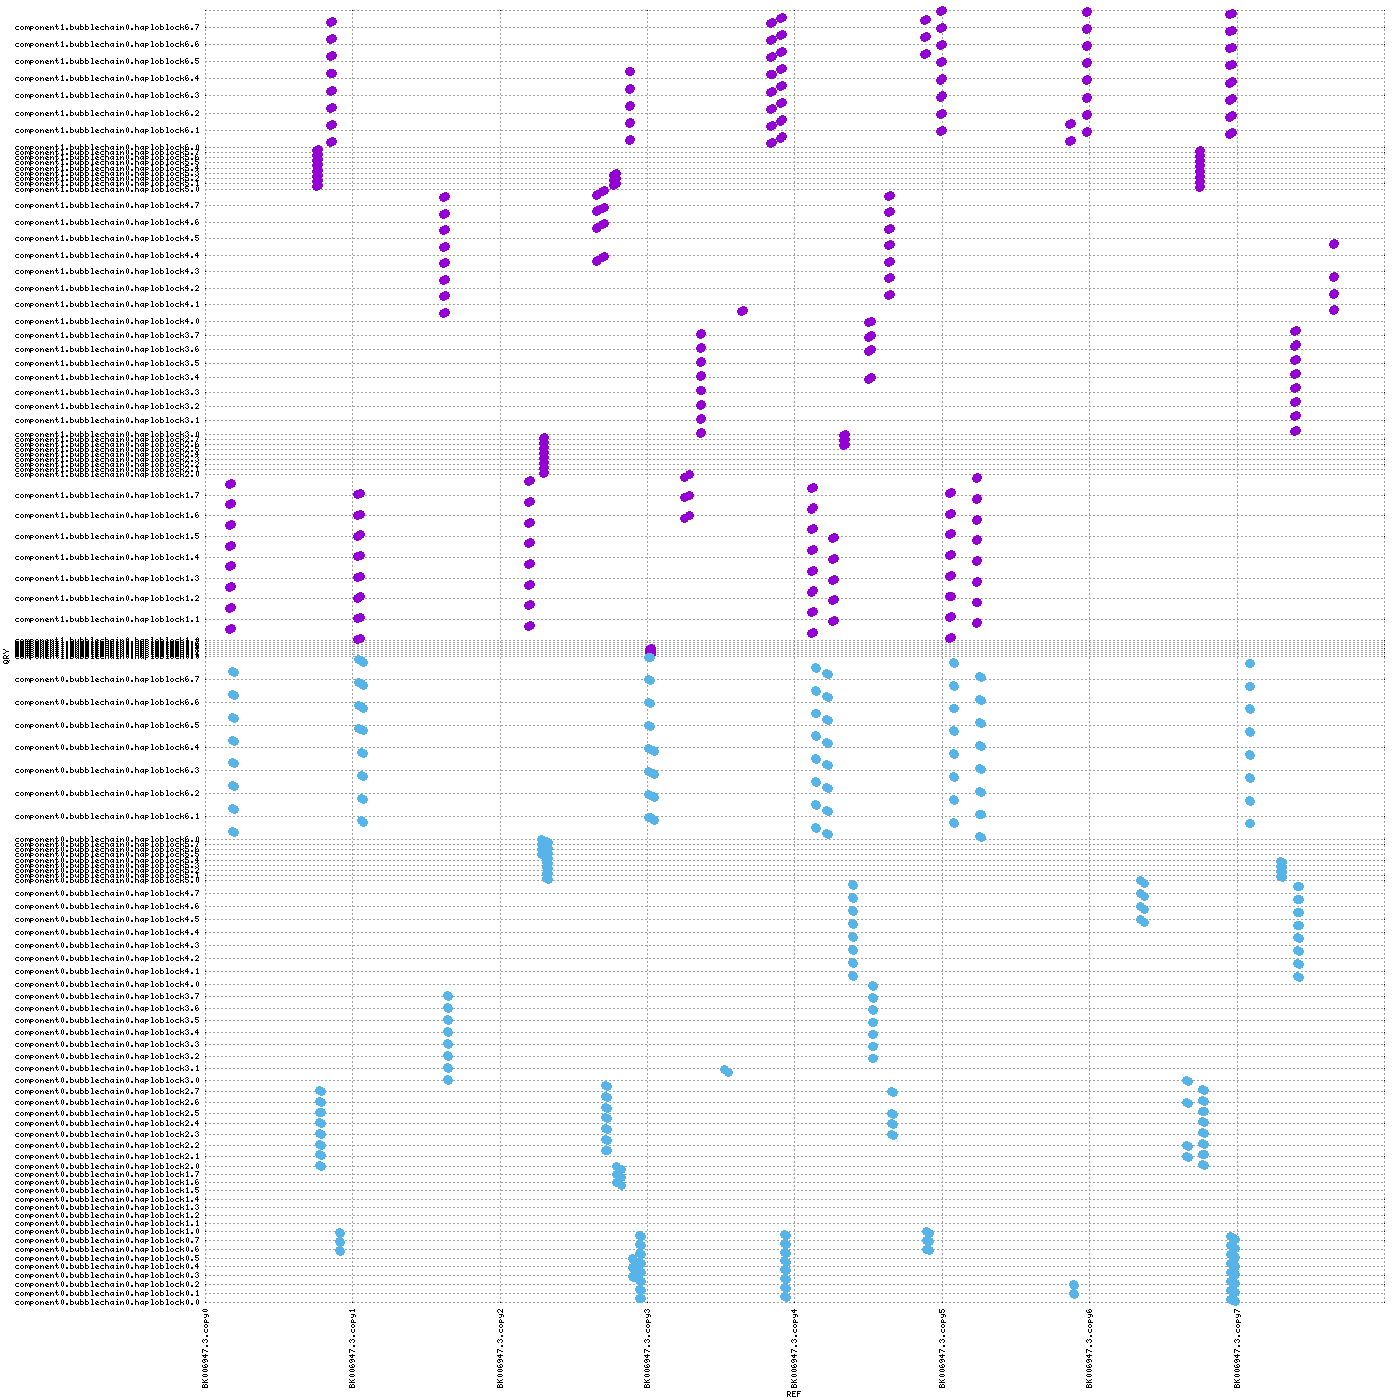

In [6]:
for assembly, asm_config in config['assemblies'].items():
    parts = assembly.split('-')
    ploidy = int(parts[0].replace("ploidy", ""))
    coverage = int(parts[1].replace("x", ""))
    
    asm_dir = os.path.join(BASE_DIR, "assemblies", assembly)
    ref_fasta = os.path.join(BASE_DIR, asm_config['reference'])
    contigs_fasta = os.path.join(asm_dir, "04_phase", assembly + ".fasta")
    prefix = os.path.join(asm_dir, "05_analysis", assembly)
    
    if coverage != 60:
        continue
        
    if not os.path.isfile(contigs_fasta):
        continue
    
    os.makedirs(os.path.dirname(prefix), exist_ok=True)
    
    nucmer('-p', prefix, '-l', 7500, '--noextend', ref_fasta, contigs_fasta)
    delta_filter('-i', 100, prefix + ".delta", _out=prefix + ".filtered.delta")
    mummerplot('-p', prefix, '--png', '--large', '-R', ref_fasta, '-Q', contigs_fasta, prefix + ".filtered.delta")
    
    with open(prefix + ".gp") as gp:
        gnuplot(_in=fix_gnuplot5(gp))
        
    display(Image(prefix + ".png"))
    cp(prefix + ".png", os.path.join(BASE_DIR, "figures", assembly + "mummer.png"))
    